<a href="https://colab.research.google.com/github/ahmed192a/AI/blob/main/LaneDetection_Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/Dt-Pham/Advanced-Lane-Lines

Cloning into 'Advanced-Lane-Lines'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 104 (delta 4), reused 1 (delta 0), pack-reused 95
Receiving objects: 100% (104/104), 95.77 MiB | 42.00 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [5]:
%cd Advanced-Lane-Lines/

/content/Advanced-Lane-Lines


#**Import Libiraries**

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import glob

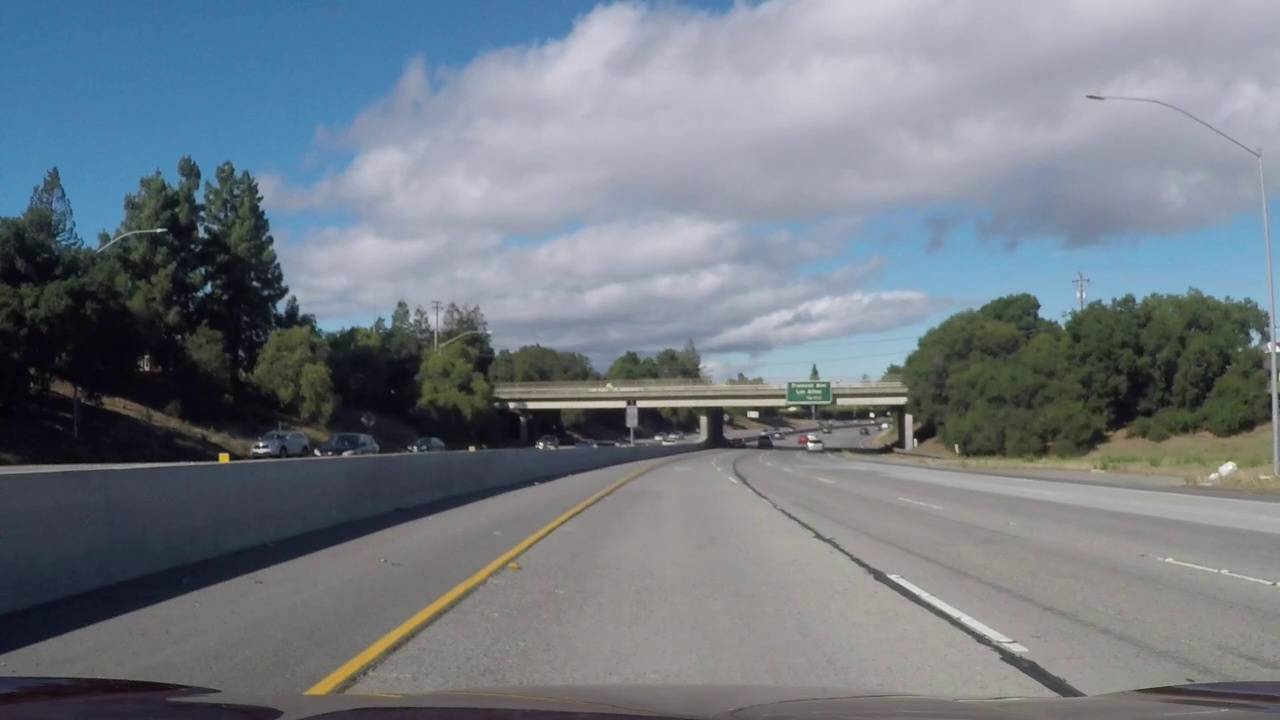

In [6]:
img = cv2.imread("test_images/challenge_video_frame_1.jpg")
cv2_imshow(img)

In [ ]:
#Constants
Windows = 10


#Camer Calibratioon

In [15]:
import os.path as path
def calibrate_camera(calib_images_dir, verbose=False):
    """
    Calibrate the camera given a directory containing calibration chessboards.
    :param calib_images_dir: directory containing chessboard frames
    :param verbose: if True, draw and show chessboard corners
    :return: calibration parameters
    """

    assert path.exists(calib_images_dir), '"{}" must exist and contain calibration images.'.format(calib_images_dir)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path.join(calib_images_dir, 'calibration*.jpg'))

    # Step through the list and search for chessboard corners
    for filename in images:
      img = cv2.imread(filename)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Find the chessboard corners
      pattern_found, corners = cv2.findChessboardCorners(gray, (9, 6), None)

      if pattern_found is True:
          objpoints.append(objp)
          imgpoints.append(corners)

          if 1:
              # Draw and display the corners
              img = cv2.drawChessboardCorners(img, (9, 6), corners, pattern_found)
              plt.imshow(img, cmap = 'gray')
              plt.show()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs
# ret, mtx, dist, rvecs, tvecs = calibrate_camera("camera_cal")


#Binarize highlight lines as much as possible

(720, 1280)

In [ ]:
def get_binary_from_equalized_grayscale(frame):
    """
    Apply histogram equalization to an input frame, threshold it and return the (binary) result.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eq_global = cv2.equalizeHist(gray)

    _, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

    return th

In [35]:
def thresh_frame_sobel(frame, kernel_size):
    """
    Apply Sobel edge detection to an input frame, then threshold the result
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

    return sobel_mag.astype(bool)

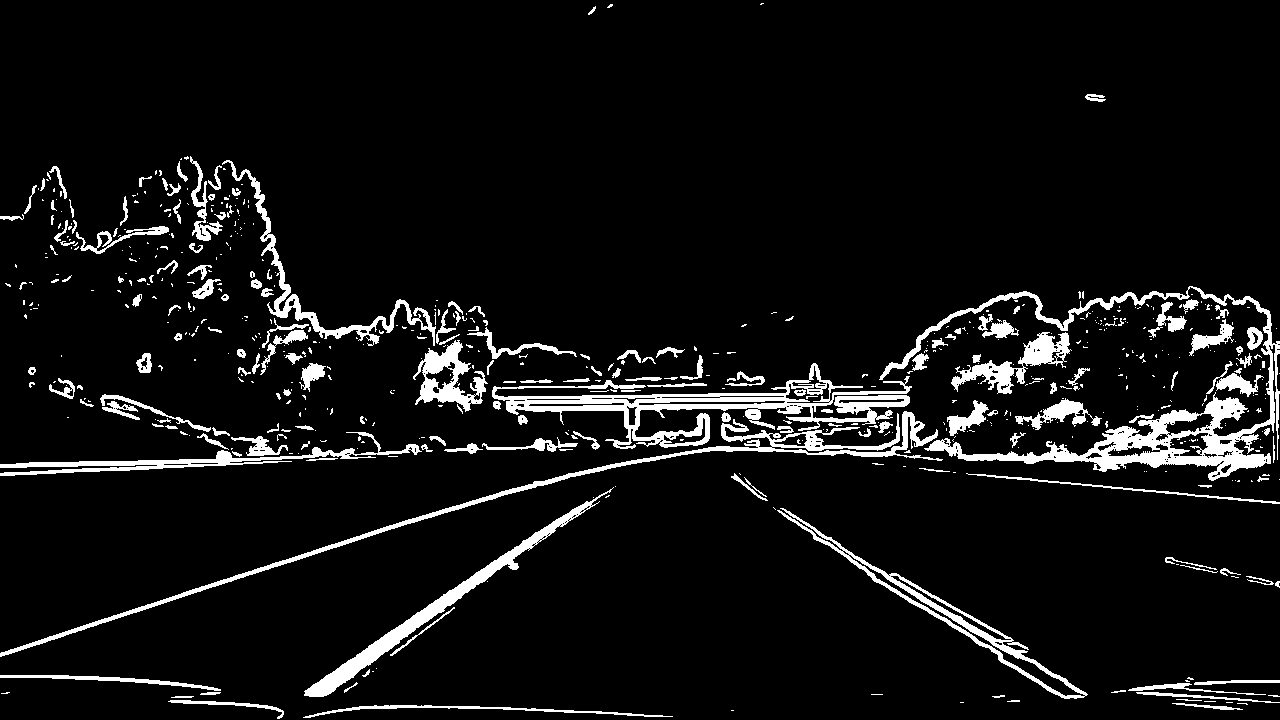

In [41]:
binary = np.zeros_like(img[:,:,0])

yellow_HSV_th_min = np.array([0, 70, 70])
yellow_HSV_th_max = np.array([50, 255, 255])

# highlight yellow lines by threshold in HSV color space
HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

min_th_ok = np.all(HSV > yellow_HSV_th_min, axis=2)
max_th_ok = np.all(HSV < yellow_HSV_th_max, axis=2)

HSV_yellow_mask = np.logical_and(min_th_ok, max_th_ok)


binary = np.logical_or(binary, HSV_yellow_mask)
# cv2_imshow(HSV_yellow_mask)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eq_global = cv2.equalizeHist(gray)
# cv2_imshow(eq_global)
# cv2_imshow(gray)
_, eq_white_mask = cv2.threshold(eq_global, thresh=200, maxval=255, type=cv2.THRESH_BINARY)
# cv2_imshow(eq_white_mask)
sobel_mask = thresh_frame_sobel(img, kernel_size=9)
binary = np.logical_or(binary, sobel_mask)
cv2_imshow(binary*255)

In [ ]:
def binarize(img):
    """
    Convert an input frame to a binary image which highlight as most as possible the lane-lines.
    :param img: input color frame
    :param verbose: if True, show intermediate results
    :return: binarized frame
    """

    binary = np.zeros_like(img[:,:,0])

    yellow_HSV_th_min = np.array([0, 70, 70])
    yellow_HSV_th_max = np.array([50, 255, 255])

    # highlight yellow lines by threshold in HSV color space
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    min_th_ok = np.all(HSV > yellow_HSV_th_min, axis=2)
    max_th_ok = np.all(HSV < yellow_HSV_th_max, axis=2)

    HSV_yellow_mask = np.logical_and(min_th_ok, max_th_ok)


    binary = np.logical_or(binary, HSV_yellow_mask)

    # highlight white lines by thresholding the equalized frame
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq_global = cv2.equalizeHist(gray)
    _, eq_white_mask = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

    #eq_white_mask = get_binary_from_equalized_grayscale(img)
    binary = np.logical_or(binary, eq_white_mask)

    # get Sobel binary mask (thresholded gradients)
    sobel_mask = thresh_frame_sobel(img, kernel_size=9)
    binary = np.logical_or(binary, sobel_mask)

    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    return closing

#Pipeline Process

In [ ]:
def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    :param frame: input color frame
    :param keep_state: if True, lane-line state is conserved (this permits to average results)
    :return: output blend with detected lane overlaid
    """

    global line_lt, line_rt, processed_frames

    # undistort the image using coefficients found in calibration
    img_undistorted = cv2.undistort(frame, mtx, dist, newCameraMatrix=mtx)

    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binarize(img_undistorted)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = birdeye(img_binary, verbose=False)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = get_fits_by_previous_fits(img_birdeye, line_lt, line_rt, verbose=False)
    else:
        line_lt, line_rt, img_fit = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=9, verbose=False)

    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])

    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    processed_frames += 1

    return blend_output


#Main Code

In [13]:
from moviepy.editor import VideoFileClip
import os
ret, mtx, dist, rvecs, tvecs = calibrate_camera("camera_cal")
mode = 'images'
if mode == 'video':

    selector = 'project'
    #clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(process_pipeline)
    #clip.write_videofile('out_{}_{}.mp4'.format(selector, time_window), audio=False)

else:

    test_img_dir = 'test_images'
    '''
    for test_img in os.listdir(test_img_dir):

        frame = cv2.imread(os.path.join(test_img_dir, test_img))

        blend = process_pipeline(frame, keep_state=False)

        cv2.imwrite('output_images/{}'.format(test_img), blend)

        plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))
        plt.show()
    '''